# knn

* knn은 lazy learning이라고 한다. eager learning의 반대되는 개념. 즉, 학습이 늦추어져 있다가 질의가 일어나는 시점에 일어남.
* knn은 매우 단순하지만 정확성이 비교적 높음.
* 입력데이터가 과다할 경우, 테스트데이터의 비교가 비효율적.

* 예를 들어, 사람마다 좋아하는 과일이 다른 경우, 

* case
    * Number of frequent flyer miles earned per year
    * Percentage of time spent playing video games
    * Liters of ice cream consumed per week

| 비행기 마일리지 | 비디오게임하는 시간 | 아이스크림 소비량 | 이상형정도 |
|-------------|----------------|---------------|------|
|2.0|3.0|2.0| 1|
|5.0|3.0|2.0| 2|





* 단위가 다른 변수는 정규화 (최소, 최대가 0~1이 되도록 변환하거나 z값을 계산하여 사용함)
* 명목변수는 0,1로 변환

## knn algorithm

* 학습단계에서는 학습데이터 (자질(features), 클래스(class label)로 이루어진 벡터)를 준비해 놓음. 준비만 하고 모델링, 연산 등은 하지 않음.
* 분류단계에서는 테스트데이터를 학습데이터 가운데 가장 가까운 k개를 골라서, 가장 많은 클래스로 투표하듯이 분류함 (majority voting)

* knn알고리듬의 입력데이터는 학습데이터(S), 테스트데이터(x), 투표갯수(k). 결과는 결정된 클래스.
    * input: S,x,c,k
        * S: training dataset m(n_features) x n(n_samples)
        * x: test instance
        * c: class label
        * k: the number of most similar examples in S 
    * output: class of x majority class

* 절차
    * for (feature,class) $\in$ S do 
        * compute the distance d(feature,x)
    * end for
    * sort d by increasing order
    * count the number of occurences of each class among the k nearest neighbors
    * Assign d the class that is the most frequent class (or the majority class).


## 알고리듬에 따른 개발

1. data read - 데이터 준비
2. distance - 학습데이터와 테스트데이터 거리(유사도) 계산
3. select k neighbors - 가장 가까운 k개 선정
4. decision - k개에서 voting하여 결정
5. accuracy - 정확성

## knn.1 준비

* 리눅스와 윈도우는 디렉토리 구분자가 서로 달라 문제를 일으킨다.
    * os에서 제공하는 기능을 사용하면 이런 문제를 해결할 수 있다.
    ```
    os.path.join()
    ```
    
* 사용자별 디렉토리가 다르다.
    * expanduser()를 사용한다.
    ```
    os.path.expanduser('~')
    ```
    
    * 또는 환경변수에 설정되어 있는 값을 사용한다.
    ```
    os.getenv('HOME')
    ```
    
    * 여기서는 다음을 정의하고 사용한다.
        * 나의 홈디렉토리 myhome
        * 나의 작업 디렉토리 mywd
        * ch2의 작업 디렉토리 ch2wd
        * ch2의 데이터 디렉토리 ch2dd

* ipython
    * 매직명령어를 뜻하는 퍼센트 사인을 사용하여, 디렉토리를 변경할 수 있다. ipython값을 쉘로 넘겨줄 때는 {}를 사용한다. 
    ```
    %cd {myhome}
    ```
    
    * 느낌표를 앞에 붙이면, 쉘 명령어를 이용할 수 있다.
    ```
    !ls
    ```

In [7]:
# directory setup
import os
myhome=os.path.expanduser('~')
mywd=os.path.join(myhome,'Code/git/jsl/algo/src/pystat/')
plantdir=os.path.join(myhome,'Code/git/gh/s/lib/')
ch2wd=os.path.join(myhome,'Code/git/else/machinelearninginaction/Ch02/')
ch2dd=os.path.join(ch2wd,'trainingDigits')
print myhome, mywd,ch2wd,ch2dd

/Users/media /Users/media/Code/git/jsl/algo/src/pystat/ /Users/media/Code/git/else/machinelearninginaction/Ch02/ /Users/media/Code/git/else/machinelearninginaction/Ch02/trainingDigits


* activity diagram
    * 알고리즘을 다이어그램으로 표현한다.

In [4]:
%install_ext https://raw.githubusercontent.com/sberke/ipython-plantuml/master/plantuml_magics.py

Installed plantuml_magics.py. To use it, type:
  %load_ext plantuml_magics


In [5]:
%load_ext plantuml_magics

The plantuml_magics extension is already loaded. To reload it, use:
  %reload_ext plantuml_magics


In [8]:
%cd {plantdir}

/Users/media/Code/git/gh/s/lib


In [9]:
import glob
glob.glob(r'./*.jar')

['./plantuml.jar']

In [10]:
import os
os.environ['GRAPHVIZ_DOT']='/opt/local/bin/dot'
print os.environ['GRAPHVIZ_DOT']
!java -jar plantuml.jar -testdot

/opt/local/bin/dot
The environment variable GRAPHVIZ_DOT has been set to /opt/local/bin/dot
Dot executable is /opt/local/bin/dot
Dot version: dot - graphviz version 2.38.0 (20140413.2041)
Installation seems OK. File generation OK


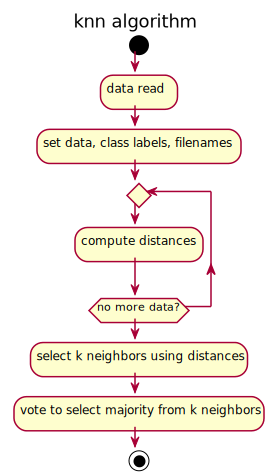

In [14]:
%%plantuml
@startuml

title knn algorithm 

start
:data read;
:set data, class labels, filenames;
repeat
    :compute distances;
repeat while (no more data?)
:select k neighbors using distances;
:vote to select majority from k neighbors;
stop

@enduml

## knn.2 data read

* 데이터는 https://github.com/pbharrin/machinelearninginaction.git
* 내려받아서 데이터파일 압축을 푼다.

* 절차
    * 파일이 저장되어 있는 dir를 찾는다.
    * dir에서 모든 파일을 읽어 목록을 만든다 (trainFiles)
    * 파일명이 클래스를 가지고 있으므로, 클래스를 분리한다.
        * 파일명의 첫 글자가 분류 값이 된다. 즉 0_1.txt파일은 첫 글자 '0'이 분류 값이 된다.


In [185]:
# git clone https://github.com/pbharrin/machinelearninginaction.git
# cd Ch02/trainingDigits; unzip digits.zip
import os

_trainFiles=[os.path.join(ch2dd, f) for f in os.listdir(ch2dd)]
_fn1=_trainFiles[1]
print "file name =",_fn1
# 파일명 첫 글자 (underscore '_'로 분리해서)가 클래스명
print "class is ",os.path.basename(_trainFiles[1]).split('_')[0]

file name = /Users/media/Code/git/else/machinelearninginaction/Ch02/trainingDigits/0_1.txt
class is  0


In [186]:
%cd {mywd}

/Users/media/Code/git/jsl/algo/src/pystat


In [187]:
# %%writefile sfun.py -a
# input: directory path
# output: list of absolute file names
def getFileList(d):
    import os
    return [os.path.join(d, f) for f in os.listdir(d)]

trainFiles=getFileList(ch2dd)
trainFiles[:5]

['/Users/media/Code/git/else/machinelearninginaction/Ch02/trainingDigits/0_0.txt',
 '/Users/media/Code/git/else/machinelearninginaction/Ch02/trainingDigits/0_1.txt',
 '/Users/media/Code/git/else/machinelearninginaction/Ch02/trainingDigits/0_10.txt',
 '/Users/media/Code/git/else/machinelearninginaction/Ch02/trainingDigits/0_100.txt',
 '/Users/media/Code/git/else/machinelearninginaction/Ch02/trainingDigits/0_101.txt']

* eof
    * 따로 정의된 eof가 없다.
    * 모든 내용을 읽어서 출력한다.
    * with를 사용하면 file을 닫을 필요가 없다.
    ```
    with open(fn) as f:
        data=f.readlines()
    ```

* readlins
    * '\r\n'이 줄마다 붙게 된다.
    * splitlines()를 사용하면 줄 분리를 해주기 때문에 없어진다. 
    ```
    with open(fn) as f:
        data=f.splitlines()
    ```

* 읽은 데이터를 저장하는 방법
    ```
    dataAll=list()
    dataAll.append(data)
    ```

* 읽은 데이터 읽기
    * 3차원으로 생각하고, 정수 인덱스를 사용하면 된다.
    ```
    dataAll[0][0][1]
    ```


In [188]:
%cd {ch2dd}
!cat 0_114.txt

/Users/media/Code/git/else/machinelearninginaction/Ch02/trainingDigits
00000000000001111000000000000000
00000000000111111001100000000000
00000000001111111111111100000000
00000000001111111111111110000000
00000000001111111111111110000000
00000000001111111111111111000000
00000000011111111110011111000000
00000000011111111000011111000000
00000000011110000000011111000000
00000000111110000000011111000000
00000000111100000000001111000000
00000000111100000000001111000000
00000000111000000000001111000000
00000000111000000000011111000000
00000001111000000000011111000000
00000001111000000000011111000000
00000001111000000000010111000000
00000001111000000000011110000000
00000001110000000000011110000000
00000001110000000000111110000000
00000011110000000000111110000000
00000011110000000000111100000000
00000011111000000001111100000000
00000011111000000011111000000000
00000001111100000011111000000000
00000001111111111111111000000000
00000000111111111111110000000000
00000000011111111111100000000000
00000

In [189]:
# readlines vs splitlines
fn0=os.path.join(dir,trainFiles[0])
with open(fn0) as f:
    data0_=f.readlines()
with open(fn0) as f:
    data0=f.read().splitlines()

In [190]:
data0_

['00000000000001111000000000000000\r\n',
 '00000000000011111110000000000000\r\n',
 '00000000001111111111000000000000\r\n',
 '00000001111111111111100000000000\r\n',
 '00000001111111011111100000000000\r\n',
 '00000011111110000011110000000000\r\n',
 '00000011111110000000111000000000\r\n',
 '00000011111110000000111100000000\r\n',
 '00000011111110000000011100000000\r\n',
 '00000011111110000000011100000000\r\n',
 '00000011111100000000011110000000\r\n',
 '00000011111100000000001110000000\r\n',
 '00000011111100000000001110000000\r\n',
 '00000001111110000000000111000000\r\n',
 '00000001111110000000000111000000\r\n',
 '00000001111110000000000111000000\r\n',
 '00000001111110000000000111000000\r\n',
 '00000011111110000000001111000000\r\n',
 '00000011110110000000001111000000\r\n',
 '00000011110000000000011110000000\r\n',
 '00000001111000000000001111000000\r\n',
 '00000001111000000000011111000000\r\n',
 '00000001111000000000111110000000\r\n',
 '00000001111000000001111100000000\r\n',
 '00000000111000

In [191]:
data0

['00000000000001111000000000000000',
 '00000000000011111110000000000000',
 '00000000001111111111000000000000',
 '00000001111111111111100000000000',
 '00000001111111011111100000000000',
 '00000011111110000011110000000000',
 '00000011111110000000111000000000',
 '00000011111110000000111100000000',
 '00000011111110000000011100000000',
 '00000011111110000000011100000000',
 '00000011111100000000011110000000',
 '00000011111100000000001110000000',
 '00000011111100000000001110000000',
 '00000001111110000000000111000000',
 '00000001111110000000000111000000',
 '00000001111110000000000111000000',
 '00000001111110000000000111000000',
 '00000011111110000000001111000000',
 '00000011110110000000001111000000',
 '00000011110000000000011110000000',
 '00000001111000000000001111000000',
 '00000001111000000000011111000000',
 '00000001111000000000111110000000',
 '00000001111000000001111100000000',
 '00000000111000000111111000000000',
 '00000000111100011111110000000000',
 '00000000111111111111110000000000',
 

In [192]:
# readlines vs splitlines
dataAll=list()
for i in range(5):
    with open(os.path.join(dir,trainFiles[i])) as f:
        dataAll.append(f.read().splitlines())

In [193]:
dataAll[1]

['00000000000111110000000000000000',
 '00000000001111111000000000000000',
 '00000000011111111100000000000000',
 '00000000111111111110000000000000',
 '00000001111111111111000000000000',
 '00000011111110111111100000000000',
 '00000011111100011111110000000000',
 '00000011111100001111110000000000',
 '00000111111100000111111000000000',
 '00000111111100000011111000000000',
 '00000011111100000001111110000000',
 '00000111111100000000111111000000',
 '00000111111000000000011111000000',
 '00000111111000000000011111100000',
 '00000111111000000000011111100000',
 '00000111111000000000001111100000',
 '00000111111000000000001111100000',
 '00000111111000000000001111100000',
 '00000111111000000000001111100000',
 '00000111111000000000001111100000',
 '00000011111000000000001111100000',
 '00000011111100000000011111100000',
 '00000011111100000000111111000000',
 '00000001111110000000111111100000',
 '00000000111110000001111111000000',
 '00000000111110000011111110000000',
 '00000000111111000111111100000000',
 

In [194]:
# input: a file list with a format of 32 rows x 32 cols
# output: list of data
def _readData(files):
    rows=32;
    cols=32;
    data = list()
    for f in files:
        fr = open(f, 'r')
        for i in range(rows):
            row=fr.readline()
            for j in range(cols):
                data.append(int(row[j]))
        fr.close()
    return data

# input: a file list
# output: list of data
# readlines -> '\r\n' -> splitlines
# eof problem -> no marker -> returns "" 
# convert string into integer problem
def readData(files):
    data=list()
    for f in files:
        with open(os.path.join(dir,f)) as fr:
            data.append(fr.read().splitlines())
    return data

_dataAll=_readData(trainFiles)
dataAll=readData(trainFiles)

* 데이터 읽기 함수의 테스트
    * 사용한 함수에 따라 데이터 모양이 다르다.
    * 파일의 개수는 1934
    * 앞의 함수는 1934파일 x 32 x 32 = 1980416
    * 뒤의 함수는 1934파일의 데이터를 반환
        * 각 1934개 데이터는 32 x 32

In [195]:
print len(trainFiles)
print len(_dataAll)
print len(dataAll)
print len(dataAll[0])
print len(dataAll[0][0])

1934
1980416
1934
32
32


### 벡터로 만드는 문제

* _readData(files) 함수는 1934 x 32 x 32개를 1줄 데이터 리스트로 읽었다.
* 1024개씩 나누어서 벡터로 구성한다.
* 절차
    * 벡터를 1934 x 1024 형식으로 초기화 한다. 그냥 0으로 초기화한다.
    ```
    np.zeros(1924,1024)
    ```
    
    * 1024개씩 읽어서 하나씩 벡터에 넣어준다.
    * 1024개의 클래스 값을 저장한다.
    * 1024개가 저장된 파일 명을 저장한다.

* 결과
    * 데이터벡터 1924 by 1024
    * 클래스 값 - 파일명의 맨 앞 글자 ('_'로 분리한 결과)
    * 파일 명

* 주의
    * 데이터, 클래스 값, 파일 명이 별도로 저장되었다. 인덱스 값으로 연관을 지어야 한다.

In [197]:
import numpy as np

#데이터를 벡터로 묶어서 만드는 연습.
a=np.array(range(0,10))
b=np.array(range(10,20))
ab=np.vstack([a,b])
print "a+b=",ab.shape
c=np.array(range(30,40))
abc=np.vstack([ab,c])
print "3x10테이블모양의 a+b+c=\n",abc

a+b= (2, 10)
3x10테이블모양의 a+b+c=
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [30 31 32 33 34 35 36 37 38 39]]


In [199]:
# 디렉토리에 있는 파일을 읽어서 벡터로 만듦.
import numpy as np
nFiles=len(trainFiles)
nRowsCols=32*32
_dataMat=np.zeros((nFiles,nRowsCols))
cLabels=list()
fileNames=list()
nTests=5
for i in range(nTests):
    filename=trainFiles[i]
    begin=i*nRowsCols
    end=begin+nRowsCols
    _dataMat[i,:]=_dataAll[begin:end]
    classNumStr=os.path.basename(filename).split('_')[0]
    cLabels.append(classNumStr)
    fileNames.append(filename)

#출력형식(formatted print)을 보기좋게
print "_dataMat{0}".format(_dataMat.shape)
print "_dataMat 1934개이지만(줄 당) 15개만 출력\n{0}".format(_dataMat[:nTests,:15])
print "cLabels %d" % len(cLabels)
print "cLabels 값 {0}".format(cLabels[:nTests])

_dataMat(1934, 1024)
_dataMat 1934개이지만(줄 당) 15개만 출력
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
cLabels 5
cLabels 값 ['0', '0', '0', '0', '0']


In [200]:
# %load -r 75-103 sfun.py
# input: list of files (one list of all files, each with a format of 32 x 32)
# output: 1) 32x32 vectors, 2) list of class labels, 3) list of file names
# dependency: _readData(files)
def readDataVector(files):
    import numpy as np
    _dataAll=_readData(files)
    nFiles=len(files)
    nRowsCols=32*32
    dataV=np.zeros((nFiles,nRowsCols))
    cLabels=list()
    fileNames=list()
    for i in range(nFiles):
        filename=files[i]
        begin=i*nRowsCols
        end=begin+nRowsCols
        dataV[i,:]=_dataAll[begin:end]
        classNumStr=os.path.basename(filename).split('_')[0]
        cLabels.append(classNumStr)
        fileNames.append(filename)
    return dataV, cLabels, fileNames

_dataMat,_cLabels,_fileNames = readDataVector(trainFiles)

nTests=5
#출력형식(formatted print)을 보기좋게
print "_dataMat{0}".format(_dataMat.shape)
print "_dataMat 1934개이지만(줄 당) 15개만 출력 {0}".format(_dataMat[:nTests,:15])
print "_cLabels %d" % len(_cLabels)
print "_cLabels 값 {0}".format(_cLabels[:nTests])

_dataMat(1934, 1024)
_dataMat 1934개이지만(줄 당) 15개만 출력 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
_cLabels 1934
_cLabels 값 ['0', '0', '0', '0', '0']


## knn.3 distance

### knn.3.1 Euclidean distance

$$\|x\| := \sqrt{x_1^2 + \cdots + x_n^2}$$

### knn.3.2 계산 방식

* numpy방식
    * numpy에서 제공하는 함수를 이용한다.
    * 선형대수 함수인 norm을 이용할 수 있다.
    * numpy를 이용하지 않고 계산할 수 있다.

* 시간측정
    * timeit를 이용하면 시간이 적게 걸리는 함수를 알 수 있다.
    * float 데이터형으로 하면 어떤지 확인해 본다.
    ```
    a=np.array([5,2,3,1,4],dtype=float)
    b=np.array([2,4,3,4,5],dtype=float)
    ```

In [201]:
import numpy as np
a=np.array([5,2,3,1,4])
b=np.array([2,4,3,4,5])
print np.linalg.norm(a-b)

#벡터연산을 하지 않는 경우
print np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2 +(a[3]-b[3])**2 +(a[4]-b[4])**2)

#어느 연산이 시간이 적게 걸리는지
import timeit
%timeit np.linalg.norm(a-b)
%timeit np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2 +(a[3]-b[3])**2 +(a[4]-b[4])**2)

4.79583152331
4.79583152331
100000 loops, best of 3: 8.94 µs per loop
The slowest run took 5.59 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.86 µs per loop


In [202]:
# %load -r 81-100 sfun.py
import numpy as np
#myV = np.array([[1.0,1.1],[1.0,1.0],[0,0],[0,0.1]])
myV=np.array([[1.0,2.0],[2.0,3.0],[0,0],[4.0,5.0]])
myX=np.array([0,0])
dNorm=list()
dNorm=[np.linalg.norm(i-myX) for i in myV]
eEucl=np.sqrt(((myV-myX)**2).sum(axis=1))
print dNorm
print eEucl

[2.2360679774997898, 3.6055512754639891, 0.0, 6.4031242374328485]
[ 2.23606798  3.60555128  0.          6.40312424]


* vector 연산을 하지 않는 경우
    * python math를 사용한다.
    * for loop를 사용하기 때문에 계산과정이 비교적 복잡해진다.
    * getDistanceUsingEq(xs, x)를 만든다.

In [203]:
import math
dMath=list()
for v in myV:
    x=v[0]-myX[0]
    y=v[1]-myX[1]
    dtemp=math.sqrt(math.pow(x,2)+math.pow(y,2))
    dMath.append(dtemp)
print dMath

[2.23606797749979, 3.605551275463989, 0.0, 6.4031242374328485]


In [204]:
# input: xs train data, x test data
# output: list of distances
def getDistanceUsingEq(xs,x):
    import math
    dMath=list()
    for item in xs:
        dtemp=0
        for i in range(len(x)):
           dtemp+=math.pow(item[i]-x[i],2)
        dtemp=math.sqrt(dtemp)
        dMath.append(dtemp)
    return dMath

# input:
# 1) sel: user selection -> one of 'norm', 'eucl" or else
# 2) xs: train data
# 3) x: test data
# output: list of distances
# dependency: getDistanceUsingEq(xs,x)
def getDistance(sel,xs,x):
    d=list()
    if sel=="norm":
        d=[np.linalg.norm(i-x) for i in xs]
    elif sel=="eucl":
        d=np.sqrt(((xs-x)**2).sum(axis=1))
    else:
        d=getDistanceUsingEq(xs,x)
    return d

myV=np.array([[1.0,2.0],[2.0,3.0],[0,0],[4.0,5.0]])
myX=np.array([0,0])
normDistances=getDistance("norm",myV,myX)
euclDistances=getDistance("eucl",myV,myX)
mathDistances=getDistance("math",myV,myX)
print normDistances
print euclDistances
print mathDistances

[2.2360679774997898, 3.6055512754639891, 0.0, 6.4031242374328485]
[ 2.23606798  3.60555128  0.          6.40312424]
[2.23606797749979, 3.605551275463989, 0.0, 6.4031242374328485]


## knn.4 select k neighbors

* numpy에서 제공하는 argsort()를 사용한다.
    * 데이터를 정렬해서, 그 인덱스를 돌려준다.
    * 거리를 계산한 결과가 [ 2.23, 3.60, 0., 6.40]인 경우
    * argsort()의 결과가 2, 0, 1, 3이면
    * 의미는 인덱스 2번째 값은 0, 0번째 2.23, 1번째 3.60, 3번째 6.40

In [205]:
# 클래스를 저장하는 associative array
myC=np.array(['C','B','A','B'])
# 인덱스를 반환한다. 2번째 0, 0번째 2.23, 1번째 3.60, 3번째 6.40
sortedDistIndices=np.array(normDistances).argsort()
print sortedDistIndices
# 가장 가까운 데이터부터 출력하면
# 가장 가까운 클래스부터 출력하면
print [myV[i] for i in sortedDistIndices]
print [myC[i] for i in sortedDistIndices]

# argsort의 실습.
# 3은 3번째인 '2', 2는 2번째인 '3', 0은 0번째인 '5', 1은 1번째 '7'
x = np.array([5, 7, 3, 2])
print np.argsort(x)
#앞의 k개를 sorting하여 가장 많은 빈도수 있는 것을 고름
k=3
print np.argsort(x)[:k]

[2 0 1 3]
[array([ 0.,  0.]), array([ 1.,  2.]), array([ 2.,  3.]), array([ 4.,  5.])]
['A', 'C', 'B', 'B']
[3 2 0 1]
[3 2 0]


In [206]:
# %load -r 139-145 sfun.py
def selectKNeighbors(data,k):
    import numpy as np
    return np.array(data).argsort()[:k]

knnIndices=selectKNeighbors(normDistances,k)
print [myV[i] for i in knnIndices]
print [myC[i] for i in knnIndices]

[array([ 0.,  0.]), array([ 1.,  2.]), array([ 2.,  3.])]
['A', 'C', 'B']


## knn.5 decision

* Python에서 제공하는 Set기능을 사용하여 빈도가 가장 높은 요소를 선정.
* most_common함수는 빈도가 가장 높은 요소와 빈도수를 내림차순으로 출력
* 전통적인 방식으로 빈도를 세어볼 수 있다.

In [207]:
# 빈도가 많은 혹은 collections를 사용
import collections
a1=['a','b','a','c']
a2=[1,2,3,4,4,4,4,2,42,5]
print collections.Counter(a1).most_common()

# 전통적인 방식 - 레이블마다 빈도를 세어보기
labelcount={}
for i in range(len(a1)):
    l=a1[i]
    if l not in labelcount:
        labelcount[l]=1
    else:
        labelcount[l]+=1

print "labelcount=",labelcount
#labelcount에서 가장빈도가 가장 높은 요소 돌려줌. 즉 a는 2회.
print "most frequent item =",collections.Counter(labelcount).most_common(1)


[('a', 2), ('c', 1), ('b', 1)]
labelcount= {'a': 2, 'c': 1, 'b': 1}
most frequent item = [('a', 2)]


In [208]:
# input: data list, nMostCommon number of most common
# output: nMostCommon list (클래스, 빈도)
def vote(data, nMostCommon):
    import collections
    return collections.Counter(data).most_common(nMostCommon)

knnClasses=[myC[i] for i in selectKNeighbors(normDistances,k)]
print vote(knnClasses, 1)


[('A', 1)]


## knn.6 알고리듬 (위 3,4,5) 묶어서 하나의 함수로

* 관련함수를 저장하고, 라이브러리로 만들어 호출
```
import sfun
```

* 변경하면
```
imp.reload(sys.modules['sfun'])
```
* 테스트
    * myX, myV, myC, k=1

In [211]:
# test: myX, myV, myC, k=1
myX=[0,0,1]
myV=np.array([[1.0,2.0,3.0],[2.0,3.0,4.0],[0,0,1],[1,1,1],[4.0,5.0,5]])
myC=np.array(['C','B','A','A','B'])
print "now classifying..."
print "\n입력데이터\n{0}가운데 {1}과 가장 가까운 데이터와 클래스를 순서대로 나열하면".format(myV, myX)
normDistances=getDistance("norm",myV,myX)
knnClasses=[myC[i] for i in selectKNeighbors(normDistances,k)]
majority=sfun.vote(knnClasses, 1)
print "----> major class는 {0}".format(majority)
#[(0,1)]의 의미는 가장 가까운(most_common)은 0번째 즉 (0,0)이 1회 발생

now classifying...

입력데이터
[[ 1.  2.  3.]
 [ 2.  3.  4.]
 [ 0.  0.  1.]
 [ 1.  1.  1.]
 [ 4.  5.  5.]]가운데 [0, 0, 1]과 가장 가까운 데이터와 클래스를 순서대로 나열하면
----> major class는 [('A', 2)]


In [219]:
# input
# 1) x: test data (features)
# 2) S: data set (list of features)
# 3) c: class
# 4) k: num of neighbhors
# output: list of majority
# usage:
# trainFiles=getFileList(ch2dd)
# dataV,cLabels,fileNames = readDataVector(trainFiles)
# majority=knnClassify(dataV[100],dataV,cLabels,3)
def knnClassify(x, S, c, k):
    normDistances=getDistance("norm",S,x)
    knnIndices=selectKNeighbors(normDistances,k)
    print "\tNeighbor indices: {0}".format(knnIndices)
    knnClasses=[c[i] for i in knnIndices]
    majority=vote(knnClasses, 1)
    print "\tmajor class -> {0}".format(majority)
    return majority, knnIndices

import os
trainFiles=getFileList(ch2dd)
dataV,cLabels,fileNames=readDataVector(trainFiles)
majority, indices=knnClassify(dataV[100],dataV,cLabels,3)
print "result -> class {0}".format(majority)
for i in indices:
    print "\t{0} -> {1}".format(i,os.path.basename(fileNames[i]))

Appending to sfun.py


## Final

* 이제 함수를 호출하여 knn 분류를 해본다.
    * 관련 함수를 라이브러리로 만든다.
    * knnClassify함수를 불러서 처리한다.

In [214]:
%cd {mywd}

/Users/media/Code/git/jsl/algo/src/pystat


In [215]:
import sfun

In [220]:
sfun.reload()

In [221]:
majority, indices=sfun.knnClassify(dataV[500],dataV,cLabels,5)
print "result -> class {0}".format(majority)
for i in indices:
    print "\t{0} -> {1}".format(i,os.path.basename(fileNames[i]))

	Neighbor indices: [500 568 414 569 519]
	major class -> [('2', 5)]
result -> class [('2', 5)]
	500 -> 2_25.txt
	568 -> 2_87.txt
	414 -> 2_122.txt
	569 -> 2_88.txt
	519 -> 2_42.txt


## knn-1: iris data를 knn분류

* 과제제출: 자신의 github
* 기한: 매주 수요일까지

In [2]:
from sklearn.datasets import load_iris
iris=load_iris()
print iris.data.shape
print iris.feature_names
print iris.target
print iris.target_names


(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
['setosa' 'versicolor' 'virginica']


In [1]:
mywd=%pwd
print mywd

/home/jsl/Code/git/bb/jsl/algo/src/pystat


In [3]:
from sklearn.datasets import load_iris
import sfun
iris=load_iris()
sfun.knnClassify(iris.data[1,],iris.data,iris.target,5)

0th col key counts [['middle' 'old' 'young']
 ['5' '5' '5']]
last col key count [['No' 'Yes']
 ['6' '9']]
(2, 2)
prob [ 0.4  0.6] allFreq 15
entropy 0.970950594455
------------------
[from computeProbVec] prob [ 0.4  0.6] all freq 15
entropy 0.970950594455
[from computeProbVec] prob [ 0.4  0.6] all freq 15
[from computeProbVec] prob [ 0.33333333  0.33333333  0.33333333] all freq 15
[computeInfoGain]prob=[ 0.33333333  0.33333333  0.33333333]
[from computeProbVec] prob [ 0.4  0.6] all freq 5
[computeInfoGain] keyToSearch=middle entropy=0.323650198152
[computeInfoGain] prob=[ 0.33333333  0.33333333  0.33333333] subData=[['middle' 'No']
 ['middle' 'No']
 ['middle' 'Yes']
 ['middle' 'Yes']
 ['middle' 'Yes']]
[from computeProbVec] prob [ 0.2  0.8] all freq 5
[computeInfoGain] keyToSearch=old entropy=0.564292896447
[computeInfoGain] prob=[ 0.33333333  0.33333333  0.33333333] subData=[['old' 'Yes']
 ['old' 'Yes']
 ['old' 'Yes']
 ['old' 'Yes']
 ['old' 'No']]
[from computeProbVec] prob [ 0.6  0.

([(0, 5)], array([ 1, 45, 12,  9, 34]))

In [ ]:
    Neighbor indices: [ 1 45 12  9 34]
    major class -> [(0, 5)]
Out[284]: ([(0, 5)], array([ 1, 45, 12,  9, 34]))